# Autoregression Model

Plot t_next-t_in versus t_in under each possible action(heating, cooling, no action).
Plot error for successive 5 min time interval

In [51]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Loading Data File

In [4]:
path = "../Data/"
building = "avenal-animal-shelter"
interval = 5 # min


with open(path + building + "_training_data.pkl", 'r') as f:
    training_data = pickle.load(f)

with open(path + building + "_test_data.pkl", "r") as f:
    test_data = pickle.load(f)
    

# Features in Dataset

In [5]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53187 entries, 2018-04-18 23:16:42+00:00 to 2018-10-25 23:13:42+00:00
Data columns (total 9 columns):
action                                        53187 non-null float64
action_duration                               53187 non-null object
dt                                            53187 non-null float64
previous_action                               42307 non-null float64
t_next                                        53187 non-null float64
t_in                                          53187 non-null float64
t_out                                         53186 non-null float64
occ                                           53186 non-null float64
zone_temperatureHVAC_Zone_Shelter_Corridor    53186 non-null float64
dtypes: float64(8), object(1)
memory usage: 4.1+ MB


# Include previous indoor temperature as t_last

In [6]:
def add_last_temperature_feature(data):
    """Adding a feature which specifies what the previous temperature was "dt" seconds before the current
    datasample. Since data does not need be continious, we need a loop.
    :param: pd.df with cols: "t_in", "dt" and needs to be sorted by time.
    returns pd.df with cols "t_last" added. """

    last_temps = []

    last_temp = None
    curr_time = data.index[0]
    for index, row in data.iterrows():

        if last_temp is None:
            last_temps.append(row["t_in"])  # so the feature will be zero instead
        else:
            last_temps.append(last_temp)

        if curr_time == index:
            last_temp = row["t_in"]
            curr_time += datetime.timedelta(minutes=row["dt"])
        else:
            last_temp = None
            curr_time = index + datetime.timedelta(minutes=row["dt"])

    data["t_last"] = np.array(last_temps)
    return data

training_data = add_last_temperature_feature(training_data)
test_data = add_last_temperature_feature(test_data)

training_data.head()

,action,action_duration,dt,previous_action,t_next,t_in,t_out,occ,zone_temperatureHVAC_Zone_Shelter_Corridor,t_last
time,,,,,,,,,,
2018-04-18 23:16:42+00:00,0.0,300.0s,5.0,NaN,69.5,69.483333,66.499700,0.0,69.499167,69.483333
2018-04-18 23:21:42+00:00,0.0,600.0s,5.0,NaN,69.5,69.500000,66.499700,0.0,69.485833,69.483333
2018-04-18 23:26:42+00:00,0.0,900.0s,5.0,NaN,69.5,69.500000,66.520546,0.0,69.460833,69.500000
2018-04-18 23:31:42+00:00,0.0,1200.0s,5.0,NaN,69.4,69.500000,66.583083,0.0,69.450000,69.500000
2018-04-18 23:36:42+00:00,0.0,1500.0s,5.0,NaN,69.5,69.400000,66.666466,0.0,69.450489,69.500000


# Preprocessing Data

Action features has values 0,1,2,3,4,5 which is transformed to values:
0 - no action
1 - heating
2 - cooling

Select the rows in datasets such that interval time is constant (5 minutes)

In [7]:
def fix_data(data, interval):
    """Fixes up the data. Makes sure we count two stage as single stage actions, don't count float actions,
    converts action duration and dt to floats, fill's nan's in action_duration and drops all datapoints which
    don't have dt equal to interval.
    :param data:
    :param interval: float:minutes"""
    def f(x):
        if x == 0:
            return 0
        elif x == 2 or x == 5:
            return 2
        elif x ==1 or x == 3:
            return 1
        
    def h(x):
        if x == 1:
            return 1
        else:
            return 0
        
    def c(x):
        if x == 2:
            return 1
        else:
            return 0

    data["action"] = data["action"].map(f)
    data['action_heating'] = data["action"].map(h)
    data['action_cooling'] = data['action'].map(c)
    
    print data.head()

    return data, data[data["dt"] == interval]

# get preproccessed test and training data
org_training_data, training_data = fix_data(training_data, interval)
org_test_data, test_data = fix_data(test_data, interval)


#print(test_data.head())

                           action action_duration   dt  previous_action  \
time                                                                      
2018-04-18 23:16:42+00:00       0          300.0s  5.0              NaN   
2018-04-18 23:21:42+00:00       0          600.0s  5.0              NaN   
2018-04-18 23:26:42+00:00       0          900.0s  5.0              NaN   
2018-04-18 23:31:42+00:00       0         1200.0s  5.0              NaN   
2018-04-18 23:36:42+00:00       0         1500.0s  5.0              NaN   

                           t_next       t_in      t_out  occ  \
time                                                           
2018-04-18 23:16:42+00:00    69.5  69.483333  66.499700  0.0   
2018-04-18 23:21:42+00:00    69.5  69.500000  66.499700  0.0   
2018-04-18 23:26:42+00:00    69.5  69.500000  66.520546  0.0   
2018-04-18 23:31:42+00:00    69.4  69.500000  66.583083  0.0   
2018-04-18 23:36:42+00:00    69.5  69.400000  66.666466  0.0   

                         

# Modifying action feature

Action is represnted as two separate features: action_heating and action_cooling, which holds value either 0(off) or 1(on). 

# Dropping Features

In [8]:
def filter_data(data):
    data = data.drop(['dt', 'action', 'previous_action', 'action_duration', 'zone_temperatureHVAC_Zone_Shelter_Corridor'], axis=1)
        
    return data

training_data = filter_data(training_data)
test_data = filter_data(test_data)

print(training_data.head())
print(test_data.head())

                           t_next       t_in      t_out  occ     t_last  \
time                                                                      
2018-04-18 23:16:42+00:00    69.5  69.483333  66.499700  0.0  69.483333   
2018-04-18 23:21:42+00:00    69.5  69.500000  66.499700  0.0  69.483333   
2018-04-18 23:26:42+00:00    69.5  69.500000  66.520546  0.0  69.500000   
2018-04-18 23:31:42+00:00    69.4  69.500000  66.583083  0.0  69.500000   
2018-04-18 23:36:42+00:00    69.5  69.400000  66.666466  0.0  69.500000   

                           action_heating  action_cooling  
time                                                       
2018-04-18 23:16:42+00:00               0               0  
2018-04-18 23:21:42+00:00               0               0  
2018-04-18 23:26:42+00:00               0               0  
2018-04-18 23:31:42+00:00               0               0  
2018-04-18 23:36:42+00:00               0               0  
                           t_next  t_in      t_out  oc

# Separating Target features 

In [9]:
def getTarget(data, target):
    y = data[target]
    return y

train_y = getTarget(training_data, 't_next')
train_y.head()

time
2018-04-18 23:16:42+00:00    69.5
2018-04-18 23:21:42+00:00    69.5
2018-04-18 23:26:42+00:00    69.5
2018-04-18 23:31:42+00:00    69.4
2018-04-18 23:36:42+00:00    69.5
Name: t_next, dtype: float64

In [10]:
def getFeatures(data, target):
    X = data.drop([target], axis=1)
    return X

train_X = getFeatures(training_data, 't_next')
train_X.head()

,t_in,t_out,occ,t_last,action_heating,action_cooling
time,,,,,,
2018-04-18 23:16:42+00:00,69.483333,66.499700,0.0,69.483333,0,0
2018-04-18 23:21:42+00:00,69.500000,66.499700,0.0,69.483333,0,0
2018-04-18 23:26:42+00:00,69.500000,66.520546,0.0,69.500000,0,0
2018-04-18 23:31:42+00:00,69.500000,66.583083,0.0,69.500000,0,0
2018-04-18 23:36:42+00:00,69.400000,66.666466,0.0,69.500000,0,0


In [11]:
test_y = getTarget(test_data, 't_next')
test_y.head()

time
2018-03-20 00:00:00+00:00    72.8
2018-03-20 00:05:00+00:00    73.0
2018-03-20 00:10:00+00:00    73.0
2018-03-20 00:15:00+00:00    73.0
2018-03-20 00:20:00+00:00    73.0
Name: t_next, dtype: float64

In [12]:
test_X = getFeatures(test_data, 't_next')
test_X.head()

,t_in,t_out,occ,t_last,action_heating,action_cooling
time,,,,,,
2018-03-20 00:00:00+00:00,72.8,67.778613,0.0,72.8,0,0
2018-03-20 00:05:00+00:00,72.8,67.807436,0.0,72.8,0,0
2018-03-20 00:10:00+00:00,73.0,67.835998,0.0,72.8,0,0
2018-03-20 00:15:00+00:00,73.0,67.864038,0.0,73.0,0,0
2018-03-20 00:20:00+00:00,73.0,67.891817,0.0,73.0,0,0


# Linear Regression Model

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time 

linearModel = LinearRegression().fit(train_X, train_y)
test_pred1 = linearModel.predict(test_X)
print test_pred1


[72.78808106 72.78814943 73.04479567 ... 72.33896613 72.339024
 72.46731324]


In [14]:
linearModel.coef_

array([ 1.28289243,  0.00237199,  0.04860689, -0.2898298 ,  0.04871555,
       -0.11557755])

In [15]:
linearModel.intercept_

0.3323518067406468

In [16]:
linearModel.score(test_X, test_y)

0.992678955494629

In [24]:
mean_squared_error(test_y, test_pred1) 

0.05248902039266961

# Lasso Regression

In [17]:
from sklearn import linear_model

lasso_clf = linear_model.Lasso(alpha=0.1)
lasso_clf.fit(train_X, train_y)
lasso_clf.score(test_X, test_y)

0.9965047187196565

# Ridge Regression

In [18]:
from sklearn.linear_model import Ridge

ridge_clf = Ridge(alpha=1.0)
ridge_clf.fit(train_X, train_y)
ridge_clf.score(test_X, test_y)

0.9927247245651246

# AutoRegression that uses previous predicted value as current t_in

In [33]:
def autoRegression(model, data_X):
    t_next5 = []
    for index, row in data_X.iterrows():
        if t_next5:
            row['t_in'] = t_next5[-1]
            if len(t_next5) > 1:
                row['t_last'] = t_next5[-2]
            else:
                row['t_last'] = data_X['t_in'].iloc[0]
        t_pred = model.predict([row])   
        t_next5.append(t_pred[0])
    return t_next5
            

# AutoRegression using Linear Model

In [31]:
t_pred5 = autoRegression(linearModel, test_X)
mean_squared_error(test_y, t_pred5) 

12.597180890809845

In [32]:
t_pred5 = autoRegression(linearModel, train_X)
mean_squared_error(train_y, t_pred5) 

6.724766264218071

# AutoRegression using Ridge Regression model

In [37]:
train_pred2 = autoRegression(ridge_clf, train_X)
mean_squared_error(train_y, train_pred2) 

6.714138561162002

In [39]:
test_pred2 = autoRegression(ridge_clf, test_X)
mean_squared_error(test_y, test_pred2)

12.583507947871679

# AutoRegression using Lasso Regression model

In [43]:
train_pred2 = autoRegression(lasso_clf, train_X)
mean_squared_error(train_y, train_pred2) 

4.453983703435345

In [44]:
test_pred2 = autoRegression(lasso_clf, test_X)
mean_squared_error(test_y, test_pred2)

7.922641626974842

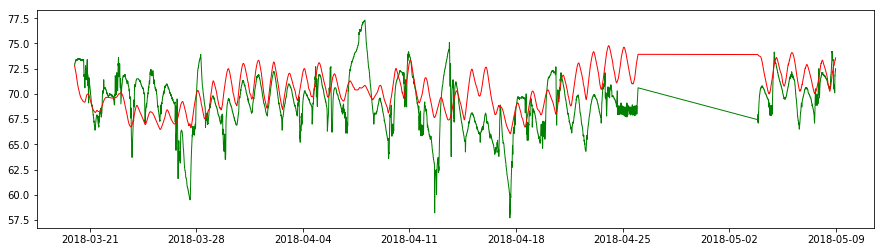

In [22]:
test_pred2 = pd.DataFrame(test_pred2, index=test_X.index)

plt.figure(figsize=(15,4))
plt.plot(test_y, 'g', linewidth=1)
plt.plot(test_pred2, 'r', linewidth=1)

# AutoRegression for successive 5 minute interval using Lasso Regression

In [82]:
def successiveTime(test_y, test_pred2):
    time = []
    rmse = []
    for x in range(0,60,5):
        time.append(x)
        x = x/5
        truth = test_y.shift(-x, axis=0).dropna()
        pred = test_pred2.shift(-x, axis=0).dropna()
        rmse.append(mean_squared_error(truth, pred))
        
    return time, rmse

time, rmse = successiveTime(test_y, test_pred2)
rmse

[7.922641626974842,
 7.923302314736168,
 7.923957455194247,
 7.924611314307766,
 7.925263779938659,
 7.925914749609539,
 7.926564116274181,
 7.927211749322434,
 7.927849409298641,
 7.928484586698436,
 7.929117200408161,
 7.929747200370427]

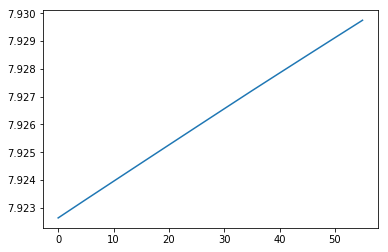

In [83]:
plt.plot(time, rmse)